In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score,classification_report,f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer 
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt 

import math
import torch
from torch import nn
from torch import optim
from torchvision.datasets import MNIST
from torch.utils.data import TensorDataset, DataLoader

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.autograd import Variable
from torchvision import datasets, transforms
import torch.utils.data as utils
from torch.optim import Adam 

In [3]:
trainloader = torch.utils.data.DataLoader(
        datasets.MNIST('MNIST_data/', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('MNIST_data/', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=16, shuffle=True)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
device = torch.device('cpu')

cuda


In [5]:
def call_pr_loss(a , variance):
    k = len(a[0])
    l = torch.sum(a**2)/ variance**2 /2/k
    return k/2*math.log(2*math.pi) + 0.5*math.log(variance**k) + l

In [6]:
m_200 = 1
m_784 = 1

In [7]:
model = nn.Sequential()
model.add_module('l1', nn.Linear(784, 200))
model.add_module('r1', nn.ReLU())
model.add_module('l2', nn.Linear(200, 200))
model.add_module('r2', nn.ReLU())
model.add_module('l3', nn.Linear(200, 200))
model.add_module('r3', nn.ReLU())
model.add_module('l4', nn.Linear(200, 200))
model.add_module('r4', nn.ReLU())
model.add_module('lf', nn.Linear(200, 10))

model.to(device)

Sequential(
  (l1): Linear(in_features=784, out_features=200, bias=True)
  (r1): ReLU()
  (l2): Linear(in_features=200, out_features=200, bias=True)
  (r2): ReLU()
  (l3): Linear(in_features=200, out_features=200, bias=True)
  (r3): ReLU()
  (l4): Linear(in_features=200, out_features=200, bias=True)
  (r4): ReLU()
  (lf): Linear(in_features=200, out_features=10, bias=True)
)

In [14]:
def eva(test_loader , model):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            data = data.view(data.size(0), -1)
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return (test_loss ,correct / len(test_loader.dataset) )

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

model.train()
step = 0 
loss_history = []
for epoch in range(1, 3):
    for batch_idx, (data, target) in enumerate(trainloader):
        
        data, target = data.to(device), target.to(device)
        data = data.view(data.size(0), -1)
        optimizer.zero_grad()
        output = model(data)
        loss_0 = criterion(output, target)
        loss_1 = call_pr_loss(model.l1.weight , m_784)
        loss_2 = call_pr_loss(model.l2.weight , m_200)
        loss_3 = call_pr_loss(model.l3.weight , m_200)
        loss_4 = call_pr_loss(model.l4.weight , m_200)
        loss_f = call_pr_loss(model.lf.weight , m_200)
        
        
        loss = loss_0 + loss_1+ loss_2+ loss_3 + loss_4 + loss_f
        loss.backward()
        optimizer.step()
        step += 1
        loss_history.append(loss.item())
        if step % 1000  == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} '.format(
                epoch, batch_idx * len(data), len(trainloader.dataset),
                100. * batch_idx / len(trainloader), loss.item()))
    scheduler.step()

Train Epoch: 1 [1584/60000 (3%)]	Loss: 1456.921387 
Train Epoch: 1 [3184/60000 (5%)]	Loss: 1456.624023 
Train Epoch: 1 [4784/60000 (8%)]	Loss: 1456.261841 
Train Epoch: 1 [6384/60000 (11%)]	Loss: 1456.219727 
Train Epoch: 1 [7984/60000 (13%)]	Loss: 1456.045654 
Train Epoch: 1 [9584/60000 (16%)]	Loss: 1456.001343 
Train Epoch: 1 [11184/60000 (19%)]	Loss: 1455.961792 
Train Epoch: 1 [12784/60000 (21%)]	Loss: 1456.341187 
Train Epoch: 1 [14384/60000 (24%)]	Loss: 1455.893188 
Train Epoch: 1 [15984/60000 (27%)]	Loss: 1455.926025 
Train Epoch: 1 [17584/60000 (29%)]	Loss: 1455.971191 
Train Epoch: 1 [19184/60000 (32%)]	Loss: 1456.134644 
Train Epoch: 1 [20784/60000 (35%)]	Loss: 1455.913574 
Train Epoch: 1 [22384/60000 (37%)]	Loss: 1455.910889 
Train Epoch: 1 [23984/60000 (40%)]	Loss: 1456.013916 
Train Epoch: 1 [25584/60000 (43%)]	Loss: 1455.991211 
Train Epoch: 1 [27184/60000 (45%)]	Loss: 1455.904297 
Train Epoch: 1 [28784/60000 (48%)]	Loss: 1455.976440 
Train Epoch: 1 [30384/60000 (51%)]	Lo

In [15]:
 c, d = eva(test_loader , model)


Test set: Average loss: 0.0061, Accuracy: 9716/10000 (97%)



0.9716

In [24]:
b = np.linspace(0.9 ,20 , 100)

In [25]:
b

array([  0.9       ,   1.09292929,   1.28585859,   1.47878788,
         1.67171717,   1.86464646,   2.05757576,   2.25050505,
         2.44343434,   2.63636364,   2.82929293,   3.02222222,
         3.21515152,   3.40808081,   3.6010101 ,   3.79393939,
         3.98686869,   4.17979798,   4.37272727,   4.56565657,
         4.75858586,   4.95151515,   5.14444444,   5.33737374,
         5.53030303,   5.72323232,   5.91616162,   6.10909091,
         6.3020202 ,   6.49494949,   6.68787879,   6.88080808,
         7.07373737,   7.26666667,   7.45959596,   7.65252525,
         7.84545455,   8.03838384,   8.23131313,   8.42424242,
         8.61717172,   8.81010101,   9.0030303 ,   9.1959596 ,
         9.38888889,   9.58181818,   9.77474747,   9.96767677,
        10.16060606,  10.35353535,  10.54646465,  10.73939394,
        10.93232323,  11.12525253,  11.31818182,  11.51111111,
        11.7040404 ,  11.8969697 ,  12.08989899,  12.28282828,
        12.47575758,  12.66868687,  12.86161616,  13.05

In [26]:
test_loss_from_var = []
accur_from_var = []
train_loss_history = []
for i in b:
    m_200 = i
    m_784 = i
    model = nn.Sequential()
    model.add_module('l1', nn.Linear(784, 200))
    model.add_module('r1', nn.ReLU())
    model.add_module('l2', nn.Linear(200, 200))
    model.add_module('r2', nn.ReLU())
    model.add_module('l3', nn.Linear(200, 200))
    model.add_module('r3', nn.ReLU())
    model.add_module('l4', nn.Linear(200, 200))
    model.add_module('r4', nn.ReLU())
    model.add_module('lf', nn.Linear(200, 10))

    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    #scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

    model.train()
    step = 0 
    loss_history = []
    for epoch in range(1, 3):
        for batch_idx, (data, target) in enumerate(trainloader):

            data, target = data.to(device), target.to(device)
            data = data.view(data.size(0), -1)
            optimizer.zero_grad()
            output = model(data)
            loss_0 = criterion(output, target)
            loss_1 = call_pr_loss(model.l1.weight , m_784)
            loss_2 = call_pr_loss(model.l2.weight , m_200)
            loss_3 = call_pr_loss(model.l3.weight , m_200)
            loss_4 = call_pr_loss(model.l4.weight , m_200)
            loss_f = call_pr_loss(model.lf.weight , m_200)


            loss = loss_0 + loss_1+ loss_2+ loss_3 + loss_4 + loss_f
            loss.backward()
            optimizer.step()
            step += 1
            loss_history.append(loss.item())
            #if step % 1000  == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} '.format(
            epoch, batch_idx * len(data), len(trainloader.dataset),
            100. * batch_idx / len(trainloader), loss.item()))
        #scheduler.step()  
        
        
    test_loss, accur = eva(test_loader , model)
    
    test_loss_from_var.append(test_loss)
    accur_from_var.append(accur)
    train_loss_history.append(loss_history)
    

Train Epoch: 1 [59984/60000 (100%)]	Loss: 1372.384033 
Train Epoch: 2 [59984/60000 (100%)]	Loss: 1372.500366 

Test set: Average loss: 0.0084, Accuracy: 9602/10000 (96%)

Train Epoch: 1 [59984/60000 (100%)]	Loss: 1526.303223 
Train Epoch: 2 [59984/60000 (100%)]	Loss: 1526.239258 

Test set: Average loss: 0.0084, Accuracy: 9598/10000 (96%)

Train Epoch: 1 [59984/60000 (100%)]	Loss: 1654.919800 
Train Epoch: 2 [59984/60000 (100%)]	Loss: 1654.964111 

Test set: Average loss: 0.0103, Accuracy: 9518/10000 (95%)

Train Epoch: 1 [59984/60000 (100%)]	Loss: 1765.590088 
Train Epoch: 2 [59984/60000 (100%)]	Loss: 1765.795410 

Test set: Average loss: 0.0105, Accuracy: 9513/10000 (95%)

Train Epoch: 1 [59984/60000 (100%)]	Loss: 1862.753296 
Train Epoch: 2 [59984/60000 (100%)]	Loss: 1862.820435 

Test set: Average loss: 0.0071, Accuracy: 9682/10000 (97%)

Train Epoch: 1 [59984/60000 (100%)]	Loss: 1949.310913 
Train Epoch: 2 [59984/60000 (100%)]	Loss: 1949.190552 

Test set: Average loss: 0.0075, Ac

C:\Apps\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in double_scalars
  after removing the cwd from sys.path.


Train Epoch: 1 [59984/60000 (100%)]	Loss: inf 
Train Epoch: 2 [59984/60000 (100%)]	Loss: inf 

Test set: Average loss: 0.0087, Accuracy: 9624/10000 (96%)

Train Epoch: 1 [59984/60000 (100%)]	Loss: inf 
Train Epoch: 2 [59984/60000 (100%)]	Loss: inf 

Test set: Average loss: 0.0110, Accuracy: 9468/10000 (95%)

Train Epoch: 1 [59984/60000 (100%)]	Loss: inf 
Train Epoch: 2 [59984/60000 (100%)]	Loss: inf 

Test set: Average loss: 0.0075, Accuracy: 9644/10000 (96%)

Train Epoch: 1 [59984/60000 (100%)]	Loss: inf 
Train Epoch: 2 [59984/60000 (100%)]	Loss: inf 

Test set: Average loss: 0.0069, Accuracy: 9685/10000 (97%)

Train Epoch: 1 [59984/60000 (100%)]	Loss: inf 
Train Epoch: 2 [59984/60000 (100%)]	Loss: inf 

Test set: Average loss: 0.0072, Accuracy: 9686/10000 (97%)

Train Epoch: 1 [59984/60000 (100%)]	Loss: inf 
Train Epoch: 2 [59984/60000 (100%)]	Loss: inf 

Test set: Average loss: 0.0063, Accuracy: 9696/10000 (97%)

Train Epoch: 1 [59984/60000 (100%)]	Loss: inf 
Train Epoch: 2 [59984/6


Train Epoch: 1 [59984/60000 (100%)]	Loss: inf 
Train Epoch: 2 [59984/60000 (100%)]	Loss: inf 

Test set: Average loss: 0.0086, Accuracy: 9601/10000 (96%)

Train Epoch: 1 [59984/60000 (100%)]	Loss: inf 
Train Epoch: 2 [59984/60000 (100%)]	Loss: inf 

Test set: Average loss: 0.0072, Accuracy: 9693/10000 (97%)

Train Epoch: 1 [59984/60000 (100%)]	Loss: inf 
Train Epoch: 2 [59984/60000 (100%)]	Loss: inf 

Test set: Average loss: 0.0092, Accuracy: 9606/10000 (96%)

Train Epoch: 1 [59984/60000 (100%)]	Loss: inf 
Train Epoch: 2 [59984/60000 (100%)]	Loss: inf 

Test set: Average loss: 0.0087, Accuracy: 9609/10000 (96%)

Train Epoch: 1 [59984/60000 (100%)]	Loss: inf 
Train Epoch: 2 [59984/60000 (100%)]	Loss: inf 

Test set: Average loss: 0.0061, Accuracy: 9728/10000 (97%)

Train Epoch: 1 [59984/60000 (100%)]	Loss: inf 
Train Epoch: 2 [59984/60000 (100%)]	Loss: inf 

Test set: Average loss: 0.0065, Accuracy: 9703/10000 (97%)

Train Epoch: 1 [59984/60000 (100%)]	Loss: inf 
Train Epoch: 2 [59984/

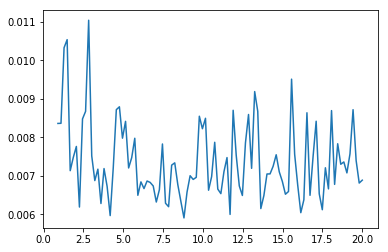

In [28]:
plt.plot(b , test_loss_from_var )

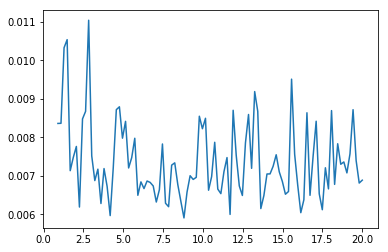

In [29]:
plt.plot( b , test_loss_from_var)

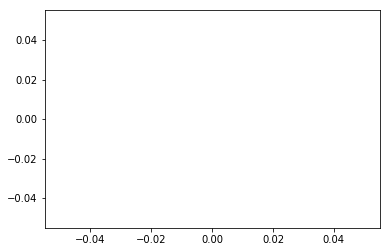

In [33]:
plt.plot(train_loss_history[59])

In [76]:
model = nn.Sequential()
model.add_module('l1', nn.Linear(784, 200))
model.add_module('r1', nn.ReLU())
model.add_module('l2', nn.Linear(200, 200))
model.add_module('r2', nn.ReLU())
model.add_module('l3', nn.Linear(200, 200))
model.add_module('r3', nn.ReLU())
model.add_module('l4', nn.Linear(200, 200))
model.add_module('r4', nn.ReLU())
model.add_module('lf', nn.Linear(200, 10))

model.to(device)

Sequential(
  (l1): Linear(in_features=784, out_features=200, bias=True)
  (r1): ReLU()
  (l2): Linear(in_features=200, out_features=200, bias=True)
  (r2): ReLU()
  (l3): Linear(in_features=200, out_features=200, bias=True)
  (r3): ReLU()
  (l4): Linear(in_features=200, out_features=200, bias=True)
  (r4): ReLU()
  (lf): Linear(in_features=200, out_features=10, bias=True)
)

In [77]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

model.train()
step = 0 
loss_history = []
for epoch in range(1, 3):
    for batch_idx, (data, target) in enumerate(trainloader):
        
        data, target = data.to(device), target.to(device)
        data = data.view(data.size(0), -1)
        optimizer.zero_grad()
        output = model(data)
        loss_0 = criterion(output, target)
        loss_1 = call_pr_loss(model.l1.weight , m_784)
        loss_2 = call_pr_loss(model.l2.weight , m_200)
        loss_3 = call_pr_loss(model.l3.weight , m_200)
        loss_4 = call_pr_loss(model.l4.weight , m_200)
        loss_f = call_pr_loss(model.lf.weight , m_200)
        
        
        loss = loss_0 + loss_1+ loss_2+ loss_3 + loss_4 + loss_f
        loss.backward()
        optimizer.step()
        step += 1
        loss_history.append(loss.item())
        if step % 1000  == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} '.format(
                epoch, batch_idx * len(data), len(trainloader.dataset),
                100. * batch_idx / len(trainloader), loss.item()))
    scheduler.step()

C:\Apps\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in double_scalars
  after removing the cwd from sys.path.


Train Epoch: 1 [15984/60000 (27%)]	Loss: inf 
Train Epoch: 1 [31984/60000 (53%)]	Loss: inf 
Train Epoch: 1 [47984/60000 (80%)]	Loss: inf 
Train Epoch: 2 [3984/60000 (7%)]	Loss: inf 
Train Epoch: 2 [19984/60000 (33%)]	Loss: inf 
Train Epoch: 2 [35984/60000 (60%)]	Loss: inf 
Train Epoch: 2 [51984/60000 (87%)]	Loss: inf 


In [36]:
eva(test_loader , model)


Test set: Average loss: 0.0052, Accuracy: 9758/10000 (98%)



(0.005213113667695143, 0.9758)

In [46]:
model.l2.weight[10][10] 

tensor(-0.0166, grad_fn=<SelectBackward>)

In [50]:
b = np.linspace(-100,100,100)

In [51]:
b

array([-100.        ,  -97.97979798,  -95.95959596,  -93.93939394,
        -91.91919192,  -89.8989899 ,  -87.87878788,  -85.85858586,
        -83.83838384,  -81.81818182,  -79.7979798 ,  -77.77777778,
        -75.75757576,  -73.73737374,  -71.71717172,  -69.6969697 ,
        -67.67676768,  -65.65656566,  -63.63636364,  -61.61616162,
        -59.5959596 ,  -57.57575758,  -55.55555556,  -53.53535354,
        -51.51515152,  -49.49494949,  -47.47474747,  -45.45454545,
        -43.43434343,  -41.41414141,  -39.39393939,  -37.37373737,
        -35.35353535,  -33.33333333,  -31.31313131,  -29.29292929,
        -27.27272727,  -25.25252525,  -23.23232323,  -21.21212121,
        -19.19191919,  -17.17171717,  -15.15151515,  -13.13131313,
        -11.11111111,   -9.09090909,   -7.07070707,   -5.05050505,
         -3.03030303,   -1.01010101,    1.01010101,    3.03030303,
          5.05050505,    7.07070707,    9.09090909,   11.11111111,
         13.13131313,   15.15151515,   17.17171717,   19.19191

In [53]:
loss_from_t = []
acc = []
s = 0
for i in b:
    model.l1.weight[10][10] = i
    test_loss, accur = eva(test_loader , model)
    loss_from_t.append(test_loss)
    acc.append(accur)
    print(s)
    s += 1
    


Test set: Average loss: 0.0066, Accuracy: 9694/10000 (97%)

0

Test set: Average loss: 0.0065, Accuracy: 9703/10000 (97%)

1

Test set: Average loss: 0.0064, Accuracy: 9705/10000 (97%)

2

Test set: Average loss: 0.0063, Accuracy: 9708/10000 (97%)

3

Test set: Average loss: 0.0063, Accuracy: 9713/10000 (97%)

4

Test set: Average loss: 0.0062, Accuracy: 9717/10000 (97%)

5

Test set: Average loss: 0.0062, Accuracy: 9716/10000 (97%)

6

Test set: Average loss: 0.0061, Accuracy: 9719/10000 (97%)

7

Test set: Average loss: 0.0061, Accuracy: 9724/10000 (97%)

8

Test set: Average loss: 0.0060, Accuracy: 9724/10000 (97%)

9

Test set: Average loss: 0.0060, Accuracy: 9728/10000 (97%)

10

Test set: Average loss: 0.0059, Accuracy: 9729/10000 (97%)

11

Test set: Average loss: 0.0059, Accuracy: 9729/10000 (97%)

12

Test set: Average loss: 0.0058, Accuracy: 9730/10000 (97%)

13

Test set: Average loss: 0.0058, Accuracy: 9730/10000 (97%)

14

Test set: Average loss: 0.0057, Accuracy: 9731/10

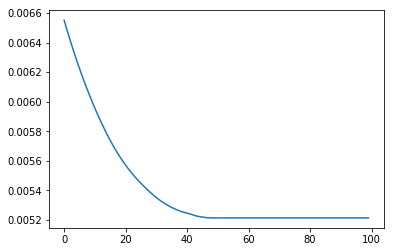

In [54]:
plt.plot(loss_from_t)

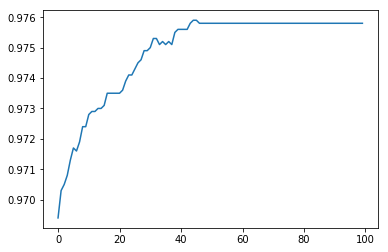

In [55]:
plt.plot(acc)

In [56]:
loss_from_t = []
acc = []
s = 0
for i in b:
    model.l2.weight[10][10] = i
    test_loss, accur = eva(test_loader , model)
    loss_from_t.append(test_loss)
    acc.append(accur)
    print(s)
    s += 1


Test set: Average loss: 0.0052, Accuracy: 9758/10000 (98%)

0

Test set: Average loss: 0.0052, Accuracy: 9758/10000 (98%)

1

Test set: Average loss: 0.0052, Accuracy: 9758/10000 (98%)

2

Test set: Average loss: 0.0052, Accuracy: 9758/10000 (98%)

3

Test set: Average loss: 0.0052, Accuracy: 9758/10000 (98%)

4

Test set: Average loss: 0.0052, Accuracy: 9758/10000 (98%)

5

Test set: Average loss: 0.0052, Accuracy: 9758/10000 (98%)

6

Test set: Average loss: 0.0052, Accuracy: 9758/10000 (98%)

7

Test set: Average loss: 0.0052, Accuracy: 9758/10000 (98%)

8

Test set: Average loss: 0.0052, Accuracy: 9758/10000 (98%)

9

Test set: Average loss: 0.0052, Accuracy: 9758/10000 (98%)

10

Test set: Average loss: 0.0052, Accuracy: 9758/10000 (98%)

11

Test set: Average loss: 0.0052, Accuracy: 9758/10000 (98%)

12

Test set: Average loss: 0.0052, Accuracy: 9758/10000 (98%)

13

Test set: Average loss: 0.0052, Accuracy: 9758/10000 (98%)

14

Test set: Average loss: 0.0052, Accuracy: 9758/10

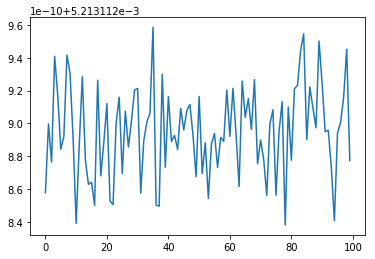

In [57]:
plt.plot(loss_from_t)

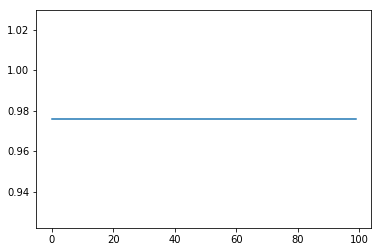

In [58]:
plt.plot(acc)

In [68]:
loss_from_t = []
acc = []
s = 0
for i in b:
    model.l3.weight[10][10] = i
    test_loss, accur = eva(test_loader , model)
    loss_from_t.append(test_loss)
    acc.append(accur)
    print(s)
    s += 1



Test set: Average loss: 0.0049, Accuracy: 9754/10000 (98%)

0

Test set: Average loss: 0.0049, Accuracy: 9754/10000 (98%)

1

Test set: Average loss: 0.0049, Accuracy: 9754/10000 (98%)

2

Test set: Average loss: 0.0049, Accuracy: 9754/10000 (98%)

3

Test set: Average loss: 0.0049, Accuracy: 9754/10000 (98%)

4

Test set: Average loss: 0.0049, Accuracy: 9754/10000 (98%)

5

Test set: Average loss: 0.0049, Accuracy: 9754/10000 (98%)

6

Test set: Average loss: 0.0049, Accuracy: 9754/10000 (98%)

7

Test set: Average loss: 0.0049, Accuracy: 9754/10000 (98%)

8

Test set: Average loss: 0.0049, Accuracy: 9754/10000 (98%)

9

Test set: Average loss: 0.0049, Accuracy: 9754/10000 (98%)

10

Test set: Average loss: 0.0049, Accuracy: 9754/10000 (98%)

11

Test set: Average loss: 0.0049, Accuracy: 9754/10000 (98%)

12

Test set: Average loss: 0.0049, Accuracy: 9754/10000 (98%)

13

Test set: Average loss: 0.0049, Accuracy: 9754/10000 (98%)

14

Test set: Average loss: 0.0049, Accuracy: 9754/10

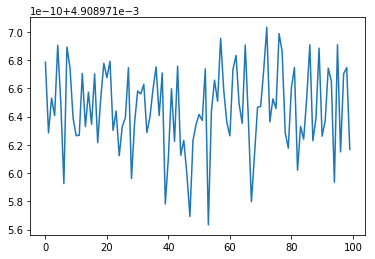

In [69]:
plt.plot(loss_from_t)


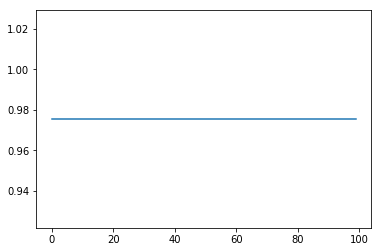

In [70]:

plt.plot(acc)

In [73]:
loss_from_t = []
acc = []
s = 0
for i in b:
    model.l4.weight[10][10] = i
    test_loss, accur = eva(test_loader , model)
    loss_from_t.append(test_loss)
    acc.append(accur)
    print(s)
    s += 1



Test set: Average loss: 0.0046, Accuracy: 9788/10000 (98%)

0

Test set: Average loss: 0.0046, Accuracy: 9788/10000 (98%)

1

Test set: Average loss: 0.0046, Accuracy: 9788/10000 (98%)

2

Test set: Average loss: 0.0046, Accuracy: 9788/10000 (98%)

3

Test set: Average loss: 0.0046, Accuracy: 9788/10000 (98%)

4

Test set: Average loss: 0.0046, Accuracy: 9788/10000 (98%)

5

Test set: Average loss: 0.0046, Accuracy: 9788/10000 (98%)

6

Test set: Average loss: 0.0046, Accuracy: 9788/10000 (98%)

7

Test set: Average loss: 0.0046, Accuracy: 9788/10000 (98%)

8

Test set: Average loss: 0.0046, Accuracy: 9788/10000 (98%)

9

Test set: Average loss: 0.0046, Accuracy: 9788/10000 (98%)

10

Test set: Average loss: 0.0046, Accuracy: 9788/10000 (98%)

11

Test set: Average loss: 0.0046, Accuracy: 9788/10000 (98%)

12

Test set: Average loss: 0.0046, Accuracy: 9788/10000 (98%)

13

Test set: Average loss: 0.0046, Accuracy: 9788/10000 (98%)

14

Test set: Average loss: 0.0046, Accuracy: 9788/10

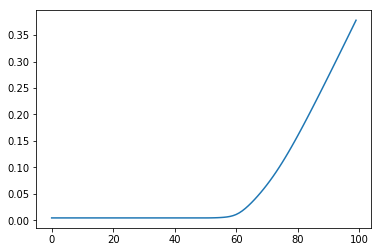

In [74]:
plt.plot(loss_from_t)

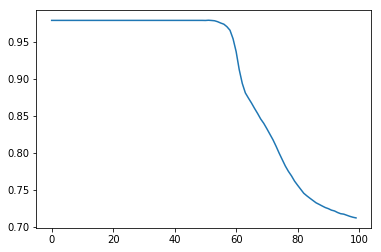

In [75]:
plt.plot(acc)

In [80]:
loss_from_t = []
acc = []
s = 0
for i in b:
    model.lf.weight[1][10] = i
    test_loss, accur = eva(test_loader , model)
    loss_from_t.append(test_loss)
    acc.append(accur)
    print(s)
    s += 1


Test set: Average loss: 0.0056, Accuracy: 9730/10000 (97%)

0

Test set: Average loss: 0.0056, Accuracy: 9730/10000 (97%)

1

Test set: Average loss: 0.0056, Accuracy: 9730/10000 (97%)

2

Test set: Average loss: 0.0056, Accuracy: 9730/10000 (97%)

3

Test set: Average loss: 0.0056, Accuracy: 9730/10000 (97%)

4

Test set: Average loss: 0.0056, Accuracy: 9730/10000 (97%)

5

Test set: Average loss: 0.0056, Accuracy: 9730/10000 (97%)

6

Test set: Average loss: 0.0056, Accuracy: 9730/10000 (97%)

7

Test set: Average loss: 0.0056, Accuracy: 9730/10000 (97%)

8

Test set: Average loss: 0.0056, Accuracy: 9730/10000 (97%)

9

Test set: Average loss: 0.0056, Accuracy: 9730/10000 (97%)

10

Test set: Average loss: 0.0056, Accuracy: 9730/10000 (97%)

11

Test set: Average loss: 0.0056, Accuracy: 9730/10000 (97%)

12

Test set: Average loss: 0.0056, Accuracy: 9730/10000 (97%)

13

Test set: Average loss: 0.0056, Accuracy: 9730/10000 (97%)

14

Test set: Average loss: 0.0055, Accuracy: 9730/10

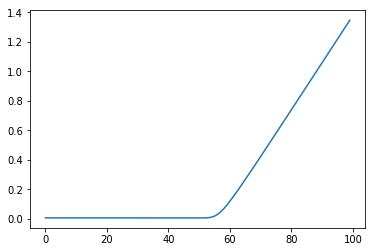

In [81]:
plt.plot(loss_from_t)

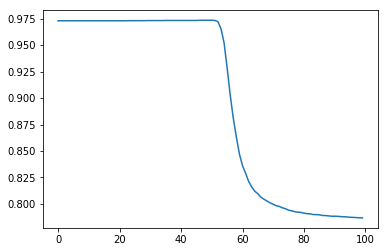

In [82]:
plt.plot(acc)